In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as stats

from collections import defaultdict
from scipy.stats.stats import pearsonr

## Loading the dataset

In [2]:
df = pd.read_csv("../dataset/customer_supermarket.csv", sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")

In [3]:
print(df.head())
print()
print(df.tail())

  BasketID          BasketDate  Sale CustomerID CustomerCountry  ProdID  \
0   536365 2010-01-12 08:26:00  2.55    17850.0  United Kingdom  85123A   
1   536365 2010-01-12 08:26:00  3.39    17850.0  United Kingdom   71053   
2   536365 2010-01-12 08:26:00  2.75    17850.0  United Kingdom  84406B   
3   536365 2010-01-12 08:26:00  3.39    17850.0  United Kingdom  84029G   
4   536365 2010-01-12 08:26:00  3.39    17850.0  United Kingdom  84029E   

                             ProdDescr  Qta  
0   WHITE HANGING HEART T-LIGHT HOLDER    6  
1                  WHITE METAL LANTERN    6  
2       CREAM CUPID HEARTS COAT HANGER    8  
3  KNITTED UNION FLAG HOT WATER BOTTLE    6  
4       RED WOOLLY HOTTIE WHITE HEART.    6  

       BasketID          BasketDate   Sale CustomerID CustomerCountry ProdID  \
541905   581587 2011-09-12 12:50:00   2.10    12680.0          France  22899   
541906   581587 2011-09-12 12:50:00   4.15    12680.0          France  23254   
541907   581587 2011-09-12 12:50

## Attributes and check

In [4]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

In [5]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  object        
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 166.8 MB


In [6]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  object        
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 32.4+ MB


,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541905,581587,2011-09-12 12:50:00,2.10,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,2011-09-12 12:50:00,4.15,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,2011-09-12 12:50:00,4.15,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4
541908,581587,2011-09-12 12:50:00,4.95,12680.0,France,22138,BAKING SET 9 PIECE RETROSPOT,3


## Observations
CustomerID and ProdDescr both feature some null values.
All the columns have wrong datatypes.

In [7]:
# drops the duplicate data from the dataset
df_nodup = df.drop_duplicates()

In [8]:
print(f"Dropped {len(df) - len(df_nodup)} duplicate rows")

Dropped 5232 duplicate rows


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  object        
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 32.4+ MB


## Printing rows with null values

In [10]:
df_null = df_nodup[df_nodup.isna().any(axis=1)]
print(df_null)
print()
print(f"We have {len(df_null)} rows with null values, \
      {len(df_null)/len(df_nodup) * 100} percent of the dataset without duplicated.")

#serializing the df with null values
df_null.to_csv("../dataset/customer_supermarket_nan.csv")


       BasketID          BasketDate     Sale CustomerID CustomerCountry  \
1444     536544 2010-01-12 14:32:00     2.51        NaN  United Kingdom   
1446     536544 2010-01-12 14:32:00     1.66        NaN  United Kingdom   
1447     536544 2010-01-12 14:32:00     1.66        NaN  United Kingdom   
1448     536544 2010-01-12 14:32:00     2.51        NaN  United Kingdom   
1450     536544 2010-01-12 14:32:00     0.43        NaN  United Kingdom   
...         ...                 ...      ...        ...             ...   
541532   581498 2011-09-12 10:26:00     4.13        NaN  United Kingdom   
541534   581498 2011-09-12 10:26:00     3.29        NaN  United Kingdom   
541538   581498 2011-09-12 10:26:00     4.96        NaN  United Kingdom   
541539   581498 2011-09-12 10:26:00    10.79        NaN  United Kingdom   
541540   581498 2011-09-12 10:26:00  1714.17        NaN  United Kingdom   

        ProdID                           ProdDescr  Qta  
1444     21774     DECORATIVE CATS BATHRO

### Dropping null columns (or not?)

We check columns with null values

In [11]:
df_nodup.isna().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

We see that the only columns with null values are CustomerID and ProdDescr.
For now we'd like to drop rows containing null values.

In [12]:
df_clean = df_nodup.dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401605 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         401605 non-null  object        
 1   BasketDate       401605 non-null  datetime64[ns]
 2   Sale             401605 non-null  float64       
 3   CustomerID       401605 non-null  object        
 4   CustomerCountry  401605 non-null  object        
 5   ProdID           401605 non-null  object        
 6   ProdDescr        401605 non-null  object        
 7   Qta              401605 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.6+ MB


In [13]:
print("Distinct values in Customer Country: \t", df_clean.CustomerCountry.unique())
#print("Distinct values in ProdID: \t", df_clean.ProdID.unique())
#print("Distinct values in ProdDescr: \t", df_clean.ProdDescr.unique())

Distinct values in Customer Country: 	 ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']


We have people coming from unspecified countries, a generic "European Community", EIRE which stands for Ireland and RSA which stands for Republic of South Africa.

In [14]:
print("Number of customers from Unspecified countries: \t", (df_clean.CustomerCountry == "Unspecified").sum())
print("Number of customers from generic European Community countries: \t", (df_clean.CustomerCountry == "European Community").sum())


Number of customers from Unspecified countries: 	 241
Number of customers from generic European Community countries: 	 61


In [15]:
df_clean.infer_objects().dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

In [16]:
print(df_clean.convert_dtypes().info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401605 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         401605 non-null  string        
 1   BasketDate       401605 non-null  datetime64[ns]
 2   Sale             401605 non-null  float64       
 3   CustomerID       401605 non-null  string        
 4   CustomerCountry  401605 non-null  string        
 5   ProdID           401605 non-null  string        
 6   ProdDescr        401605 non-null  string        
 7   Qta              401605 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), string(5)
memory usage: 28.0 MB
None


In [17]:
df_clean.describe()

,Sale,Qta
count,401605.000000,401605.000000
mean,3.474100,12.183245
std,69.763952,250.282726
min,0.000000,-80995.000000
25%,1.250000,2.000000
50%,1.950000,5.000000
75%,3.750000,12.000000
max,38970.000000,80995.000000


In [18]:
df_clean['CustomerID'] = pd.to_numeric(df_clean.CustomerID)
df_clean.CustomerID = df_clean.CustomerID.astype(int)

/Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
df_clean.info()
df_clean

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401605 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         401605 non-null  object        
 1   BasketDate       401605 non-null  datetime64[ns]
 2   Sale             401605 non-null  float64       
 3   CustomerID       401605 non-null  int64         
 4   CustomerCountry  401605 non-null  object        
 5   ProdID           401605 non-null  object        
 6   ProdDescr        401605 non-null  object        
 7   Qta              401605 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.6+ MB


,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541905,581587,2011-09-12 12:50:00,2.10,12680,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,2011-09-12 12:50:00,4.15,12680,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,2011-09-12 12:50:00,4.15,12680,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4
541908,581587,2011-09-12 12:50:00,4.95,12680,France,22138,BAKING SET 9 PIECE RETROSPOT,3


The only attribute that still has a wrong datatype is BasketID, we have to remove letters at the beginning of the ID.

In [20]:
# regex matchin everything except digits
regex = "\D+"
df_regex = df_clean.replace(to_replace=r'\D+', value='', regex=True)
df_regex.BasketID = pd.to_numeric(df_regex.BasketID)
df_regex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401605 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         401605 non-null  int64         
 1   BasketDate       401605 non-null  datetime64[ns]
 2   Sale             401605 non-null  float64       
 3   CustomerID       401605 non-null  int64         
 4   CustomerCountry  401605 non-null  object        
 5   ProdID           401605 non-null  object        
 6   ProdDescr        401605 non-null  object        
 7   Qta              401605 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 27.6+ MB


In [21]:
df_regex.describe()

,BasketID,Sale,CustomerID,Qta
count,401605.000000,401605.000000,401605.000000,401605.000000
mean,560556.245064,3.474100,15281.154341,12.183245
std,13086.518607,69.763952,1714.008869,250.282726
min,536365.000000,0.000000,12346.000000,-80995.000000
25%,549130.000000,1.250000,13939.000000,2.000000
50%,561814.000000,1.950000,15145.000000,5.000000
75%,572034.000000,3.750000,16784.000000,12.000000
max,581587.000000,38970.000000,18287.000000,80995.000000


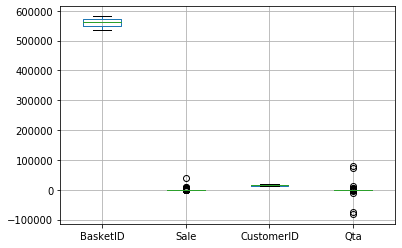

In [29]:
boxplot = df_regex.boxplot()

### Correlation matrix

In [30]:
correlations = df_regex.corr(method="pearson")
correlations

,BasketID,Sale,CustomerID,Qta
BasketID,1.000000,-0.002550,0.001233,-0.001680
Sale,-0.002550,1.000000,-0.004525,-0.001243
CustomerID,0.001233,-0.004525,1.000000,-0.003456
Qta,-0.001680,-0.001243,-0.003456,1.000000


There seems to be absolutely no correlation between the values of the dataset

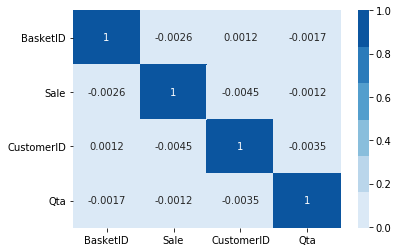

In [39]:
import seaborn as sns

cmap = sns.color_palette("Blues")
sns.heatmap(correlations, annot=True, cmap=cmap)
plt.show()

We clearly have a problem with outliers

We group every product that has been bought by the same customer in the same basket but has a different Qta, in order to get the correct amout of bought items

In [22]:
df_grouped = df_regex.groupby(['BasketID','BasketDate','ProdID'])['Qta'].sum()

In [25]:
df_grouped.describe()
df_grouped

BasketID  BasketDate           ProdID
536365    2010-01-12 08:26:00  21730      6
                               22752      2
                               71053      6
                               84029     12
                               84406      8
                                         ..
581587    2011-09-12 12:50:00  22730      4
                               22899      6
                               23254      4
                               23255      4
                               23256      4
Name: Qta, Length: 389122, dtype: int64

Seems like we have a lot of problems with outliers in Sale and Qta rows.
We proceed to filter them out.

In [23]:
import scipy

zscores = scipy.stats.zscore(df_regex)
abs_zscores = np.abs(zscore)
filtered_outliers = (abs_zscores < 3).all(axis = 1)

df_no_outliers = df_regex(filtered_outliers)

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

In [ ]:
df_no_outliers.describe
df_no_outliers